## Introduction 

The following notebook contains a demo of a method for sequence aware product recommendation. In particular, the [Short-term and Long-term preference Integrated
Recommender system](https://www.microsoft.com/en-us/research/uploads/prod/2019/07/IJCAI19-ready_v1.pdf) (SLi-Rec) method is applied to the [Amazon Review Dataset](https://nijianmo.github.io/amazon/index.html). Specifically, the Movies and TV dataset is used which contains 8,765,568 reviews of 203,970 products. 

## Short-term and Long-term preference Integrated Recommender system (SLi-Rec)

In this tutorial, we will specifically explore the SLi-Rec method. SLi-Rec jointly models long term preferences with an Attentive Asymmetric SVD (A2SVD) and short term preferences with an RNN. The RNN is chosen to be an LSTM that is extended to include a time aware and context aware controller that enhance the state transition function to consider temporal and contextual information, respectively. The long term and short term preferences are combined dynamically based on the context. 

<p align="center">
<img width="725" alt="image" src="https://user-images.githubusercontent.com/34798787/182885911-9e0a3492-b716-4266-a65d-298c2726476b.png">
 </p> 

### Short Term Perferences

SLi-Rec leverages an augmented LSTM to generate the short term preferences of users. In general, the LSTM is an RNN thats specified as follows: 

<p align="center">
<img width="847" alt="lstm4" src="https://user-images.githubusercontent.com/34798787/179023828-c610daa2-29a8-4894-920f-6e7d1b3aa5f5.png">
</p>

The input of an LSTM cell consists of an embedding encoding the latest user interaction $x_t$, the previous hidden state $h_{t-1}$ and the previous cell status $c_{t-1}$. The output of an LSTM cell consists of the current hidden state $h_t$ and cell status $c_t$. $i_t$, $o_t$ and $f_t$ are the input, output and forget gate, respectively. They  modulate the flow of data throughout the LSTM cell. The gates are parametized by trainiable weight matrices $U^*$ and $W^*$ as well as bias vectors $b^*$. The activation functions used in the LSTM cell include the sigmoid function $\sigma$ and the tanh function $\phi$. 

In some domains such as NLP, we can consider items in a sequence evenly spaced and semantically equivalent. However, the dynamics of user behaviour is much more complicated. As such, novel components are proposed to address the following challenges: 

1. **Time Irregularity:** Time intervals between actions vary.  To address time irregularity, the gate logic of the LSTM is augmented to make it sensitive time changes. 
2. **Semantic Irregularity:** Items within a users behaviour sequence may not always share the same semantic topic. To address semantic irregularity, an attention mechanism is adopted to suppress the contribution of interactions that are dissimilar to a given target item sematically. 

### Long Term Preferences
Matrix factorization approaches have been widely used to model the long term preferences of users. In the standard setup, user and item latent factors are determined such that there product approximates the ratings matrix.

<p align="center">
<img width="578" alt="image" src="https://user-images.githubusercontent.com/34798787/182884378-e5ae066e-8055-493a-9027-35c5e773c27a.png">
</p>

Early approaches to matrix factoriztion use a singular value decomposition (SVD) to determine the item and latent factors. In practice, the ratings matrix is sparse so the SVD can be ineffective. Instead, stochastic gradient descent is often used to learn user factors $p_i$ and item factors $q_j$ that approximate **observed** ratings $r_{i, j}$ 


$$
\begin{eqnarray}
\min_{p, q} 
\sum_{i, j \in R}{(r_{i, j} - p_i^T q_j)^2 + \lambda(||p_i||^2 + ||q_j||^2)}
\end{eqnarray}
$$

Matrix factorization approaches that avoid explicitly parametizing users have also been proposed. The size of the item set is typically much smaller than the size of the user set so this drastically reduces the amount of parameters. An example of one such approach is the Asymmetric-SVD which represents users as combination of item latent factors $q_j$ weighted by coefficients $a_{k}^{l}$:

$$
\begin{eqnarray}
p_u = \sum_{j \in R} a_{j} q_j
\end{eqnarray}
$$

$a_j$ is the weigting score for behaviour $j$. Thus, it should assign a higher weights to behaviours that are more informative. In the recently proposed [Short-term and Long-term preference Integrated
Recommender system](https://www.microsoft.com/en-us/research/uploads/prod/2019/07/IJCAI19-ready_v1.pdf) (SLi-Rec), $a_j$ is computed as an attention score across items a user has interacted with. The resulting model is reffered to as Attentive Asymmetric Singular Value Decomposition (A2SVD). A2SVD is used in the SLi-Rec to model long term preferences of users. 

### Adaptive Fusion
To generate the final output, the prediction from the short-term and long-term model are fused based on the context using attention. For more details about this operation, or any other details regarding the method, please refer to the [paper](https://www.ijcai.org/proceedings/2019/0585.pdf).

## Package Imports and Global Variables

In [1]:
# Package Imports
import os
import time
import warnings

import numpy as np 
import pandas as pd
import tensorflow as tf
import tensorboard as tb
import matplotlib.pyplot as plt

from recommenders.utils.timer import Timer
from recommenders.models.deeprec.deeprec_utils import prepare_hparams
from recommenders.models.deeprec.io.sequential_iterator import SequentialIterator

# Local Imports 
from utils import create_vocab
from model import SLI_RECModel_Custom as SeqModel

In [2]:
DATA_PATH = "../data/amazon"
BASE_LOG_PATH = "logs"
BASE_MODEL_PATH = "models"
REVIEWS_FILE = 'reviews_Movies_and_TV_5.json'
META_FILE = 'meta_Movies_and_TV.json'

YAML_PATH = "config/sli_rec.yaml"


EPOCHS = 10
BATCH_SIZE = 400
RANDOM_SEED = 42

train_num_ngs = 4
valid_num_ngs = 4

In [3]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
# Directories to store train, validation and test splits
train_path = os.path.join(DATA_PATH, r'train_data')
valid_path = os.path.join(DATA_PATH, r'valid_data')
test_path = os.path.join(DATA_PATH, r'test_data')

# Files paths to store the list of existing ids for user, item and item category 
user_vocab_path = os.path.join(DATA_PATH, r'user_vocab.pkl')
item_vocab_path = os.path.join(DATA_PATH, r'item_vocab.pkl')
cate_vocab_path = os.path.join(DATA_PATH, r'category_vocab.pkl')
output_file_path = os.path.join(DATA_PATH, r'output.txt')

# File paths to store reviews and associated metadata
reviews_path = os.path.join(DATA_PATH, REVIEWS_FILE)
meta_path = os.path.join(DATA_PATH, META_FILE)

valid_num_ngs = 4 # number of negative instances with a positive instance for validation
test_num_ngs = 9 # number of negative instances with a positive instance for testing

# create run drectory to store results
if os.path.exists(BASE_MODEL_PATH) == False:
    os.mkdir(BASE_MODEL_PATH)
    
MODEL_PATH = f"{BASE_MODEL_PATH}/{str(time.time())}"

if os.path.exists(BASE_LOG_PATH) == False:
    os.mkdir(BASE_LOG_PATH)

LOG_PATH = f"{BASE_LOG_PATH}/{str(time.time())}"

## Data Loading 

Given that the data is preprocessed in the [amazon_preprocessing notebook](amazon_preprocessing.ipynb), no further processing is required. In this section, we will briefly analyze the train, validation and test sets to get aquainted with the data we will be modelling. Futhermore, a data loader will be defined to iteratively fetch samples from the datasets during training and evaluation. 

The train dataset consists of a dataframe where each record is a review of a product `item_id` in category `cate_id` at time `timestamp` by user `user_id`. Each record also contains the list of previous items the user interacted with `prev_ids` along with the corresponding categories `prev_cate_ids` and timestamps `prev_timestamps`.

In [5]:
train_df = pd.read_csv(train_path, sep="\t", index_col=False, names=["label", "user_id", "item_id", "cate_id", "timestamp", "prev_item_ids", "prev_cate_ids", "prev_timestamps"])
train_df

,label,user_id,item_id,cate_id,timestamp,prev_item_ids,prev_cate_ids,prev_timestamps
0,1,AWF2S3UNW9UA0,B008220C38,Movies,1362441600,B005LAIHQS,Movies,1361232000
1,1,AWF2S3UNW9UA0,B009AMANBA,Movies,1365033600,"B005LAIHQS,B008220C38","Movies,Movies","1361232000,1362441600"
2,1,AWF2S3UNW9UA0,B00B74MJOS,Movies,1367625600,"B005LAIHQS,B008220C38,B009AMANBA","Movies,Movies,Movies","1361232000,1362441600,1365033600"
3,1,AWF2S3UNW9UA0,B0067EKYL8,Movies,1371686400,"B005LAIHQS,B008220C38,B009AMANBA,B00B74MJOS","Movies,Movies,Movies,Movies","1361232000,1362441600,1365033600,1367625600"
4,1,AWF2S3UNW9UA0,0792839072,Movies,1372982400,"B005LAIHQS,B008220C38,B009AMANBA,B00B74MJOS,B0...","Movies,Movies,Movies,Movies,Movies","1361232000,1362441600,1365033600,1367625600,13..."
...,...,...,...,...,...,...,...,...
16630,1,A1WZZDWYPVST2M,B008JFUUIA,Movies,1365552000,B005S9ELM6,Movies,1365552000
16631,1,A37K6TJ94ZFXVQ,B008JFUOWM,Movies,1390262400,B00B74MJOS,Movies,1368144000
16632,1,A16342W88H5YWK,B0090SI3ZW,Movies,1364256000,B007R6D74G,Movies,1348185600
16633,1,AA3UZRM4EFLK2,B0067EKYL8,Movies,1365465600,B005S9ELM6,Movies,1365465600


The validation and test datasets share the schema as the train dataset. Positive samples are interactions between users and items that have occured. Alternatively, negative samples are interactions between users and items that have not occured. In addition to being used in the training phase, negative samples are included in the validation and test sets so we can compute metrics of how well the generated recommendations approximate the users actual behaviour. 

In [6]:
# Visualize validation dataset dataframe
valid_df = pd.read_csv(valid_path, sep="\t", index_col=False, names=["label", "user_id", "item_id", "cate_id", "timestamp", "prev_item_ids", "prev_cate_ids", "prev_timestamps"])
valid_df

,label,user_id,item_id,cate_id,timestamp,prev_item_ids,prev_cate_ids,prev_timestamps
0,1,AWF2S3UNW9UA0,B00005K3OT,Movies,1393718400,"B005LAIHQS,B008220C38,B009AMANBA,B00B74MJOS,B0...","Movies,Movies,Movies,Movies,Movies,Movies,Movi...","1361232000,1362441600,1365033600,1367625600,13..."
1,0,AWF2S3UNW9UA0,B0090SI3ZW,Movies,1393718400,"B005LAIHQS,B008220C38,B009AMANBA,B00B74MJOS,B0...","Movies,Movies,Movies,Movies,Movies,Movies,Movi...","1361232000,1362441600,1365033600,1367625600,13..."
2,0,AWF2S3UNW9UA0,B00E8RK5OC,Movies,1393718400,"B005LAIHQS,B008220C38,B009AMANBA,B00B74MJOS,B0...","Movies,Movies,Movies,Movies,Movies,Movies,Movi...","1361232000,1362441600,1365033600,1367625600,13..."
3,0,AWF2S3UNW9UA0,6305171769,Movies,1393718400,"B005LAIHQS,B008220C38,B009AMANBA,B00B74MJOS,B0...","Movies,Movies,Movies,Movies,Movies,Movies,Movi...","1361232000,1362441600,1365033600,1367625600,13..."
4,0,AWF2S3UNW9UA0,B00005JPFX,Movies,1393718400,"B005LAIHQS,B008220C38,B009AMANBA,B00B74MJOS,B0...","Movies,Movies,Movies,Movies,Movies,Movies,Movi...","1361232000,1362441600,1365033600,1367625600,13..."
...,...,...,...,...,...,...,...,...
34360,1,A173F44ZGP878J,B00E8RK5OC,Movies,1383264000,B009AMANBA,Movies,1365811200
34361,0,A173F44ZGP878J,B00005JPS8,Movies,1383264000,B009AMANBA,Movies,1365811200
34362,0,A173F44ZGP878J,B009934S5M,Movies,1383264000,B009AMANBA,Movies,1365811200
34363,0,A173F44ZGP878J,B000E1MTYK,Movies,1383264000,B009AMANBA,Movies,1365811200


In [7]:
# Visualize test dataset dataframe
test_df = pd.read_csv(test_path, sep="\t", index_col=False, names=["label", "user_id", "item_id", "cate_id", "timestamp", "prev_item_ids", "prev_cate_ids", "prev_timestamps"])
test_df

,label,user_id,item_id,cate_id,timestamp,prev_item_ids,prev_cate_ids,prev_timestamps
0,1,A3R27T4HADWFFJ,B0000AZT3R,Movies,1389657600,B000J10EQU,Movies,1387756800
1,0,A3R27T4HADWFFJ,B0000VD02Y,Movies,1389657600,B000J10EQU,Movies,1387756800
2,0,A3R27T4HADWFFJ,B00005JPS8,Movies,1389657600,B000J10EQU,Movies,1387756800
3,0,A3R27T4HADWFFJ,B00003CXXO,Movies,1389657600,B000J10EQU,Movies,1387756800
4,0,A3R27T4HADWFFJ,B000C3L27K,Movies,1389657600,B000J10EQU,Movies,1387756800
...,...,...,...,...,...,...,...,...
169165,0,AGAWDSE1J20RI,B002ZG98R8,Movies,1405468800,B00H7KJTCG,Movies,1405468800
169166,0,AGAWDSE1J20RI,B00005JPFX,Movies,1405468800,B00H7KJTCG,Movies,1405468800
169167,0,AGAWDSE1J20RI,B000AE4QD8,TV,1405468800,B00H7KJTCG,Movies,1405468800
169168,0,AGAWDSE1J20RI,B000BTJDG2,Movies,1405468800,B00H7KJTCG,Movies,1405468800


When training and evaluating neural network models, we typically feed batches of input into the model to generate predictions. This involves iterively sampling batches of data in the dataset . The [microsoft recommenders](https://github.com/microsoft/recommenders) package provides the `SequentialIterator` class which acts as a dataloader for sequential recommender systems such as SLi-Rec. 

In [8]:
input_creator = SequentialIterator

Following the definition of the Sequential Dataset, we need to generate the user, item and category files using the `utils.create_vocab` function. These files contain the unique ids of each user, item and category in the dataset, respectively. This is leveraged by the model to generate embedding tables of the proper dimension. 

In [9]:
create_vocab(train_path, user_vocab_path, item_vocab_path, cate_vocab_path)

## Model Definition

With the sequential dataset in place, we can turn our attention to defining the SLi-Rec model. The [microsoft recommenders](https://github.com/microsoft/recommenders) package provides a variety of recommender methods including SLi-Rec. It provides a uniform interface for both sequential and non-sequential recommender system methods. 

The first step to defining a model is generating the hyperameters `hparams` using the `recommenders.models.deeprec.deeprec_utils.prepare_hparams` function. This function takes a varitey of arguments including model, log save paths and vocabulary file paths along with hyperparameters such as batch size and epochs. The majority of hyperparameters are started in a yaml path at `YAML_PATH`. The microsoft recommenders package provides a [yaml file](https://github.com/microsoft/recommenders/tree/main/recommenders/models/deeprec/config) with default hyperparameters for each of the sequential architectures it supports. There a four types of hyperparameters that are stored in the yaml file: **data**, **model**, **train** and **info**. Below we list a few of the prominent hyperparameters for each type. 

#### Data Hyperparameters
- **user_vocab**: The map file of user to id
- **item_vocab**: The map file of item to id
- **cate_vocab**: The map file of category to id

#### Model Hyperparameters
- **method**: classification or regression
- **layer_sizes**: Number of nodes per layer of DNN
- **activation**: Activation function per layer of DNN
- **dropout**: Dropout proportion per layer of DNN

#### Train Hyperparameters
- **loss**: The data loss to use (pointwise: log_loss, cross_entropy_loss, square_loss  pairwise: softmax)
- **optimizer**: The optimizer to use during training (adam, adadelta, sgd, ftrl, gd, padagrad, pgd, rmsprop)
- **batch_size**:  The number of samples per batch
- **epochs**: The number of times to iterate through the training set
- **train_num_ngs**: The number of negative instances to include per postive instance in training set 
- **learning_rate**: Determines the step size of updates to model parameters

#### Info Hyperparameters
- **save_model**: Whether or not to save model 
- **save_epoch**: Frequency in which model is saved 
- **metrics**: Metrics for evaluation

In [10]:
hparams = prepare_hparams(YAML_PATH, 
                          embed_l2=0., 
                          layer_l2=0., 
                          learning_rate=0.001,  # set to 0.01 if batch normalization is disable
                          epochs=EPOCHS,
                          batch_size=BATCH_SIZE,
                          show_step=20,
                          MODEL_DIR=os.path.join(MODEL_PATH),
                          SUMMARIES_DIR=os.path.join(LOG_PATH),
                          user_vocab=user_vocab_path,
                          item_vocab=item_vocab_path,
                          cate_vocab=cate_vocab_path,
                          need_sample=True,
                          train_num_ngs=train_num_ngs, # provides the number of negative instances for each positive instance for loss computation.
            )

To define the model, we pass the hyperparameters, sequential dataset and seed to the `models.SLI_RECModel_Custom` constructor. The `models.SLI_RECModel_Custom` class is a simple extension of the `recommenders.models.deeprec.models.sequential.sli_rec.SLI_RECModel` that overrides the `fit` method to more easily access train and evaluation metrics accross epochs. This is done as a convenience and is by no means required by package. 

In [11]:
model = SeqModel(hparams, input_creator, seed=RANDOM_SEED)

Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Colocations handled automatically by placer.


/h/jewtay/.local/lib/python3.7/site-packages/recommenders/models/deeprec/models/base_model.py:705: UserWarning: `tf.layers.batch_normalization` is deprecated and will be removed in a future version. Please use `tf.keras.layers.BatchNormalization` instead. In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.BatchNormalization` documentation).
  training=self.is_train_stage,
2022-08-17 09:46:41.628357: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-17 09:46:43.767918: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13795 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0

## Training and Validation

The next step is to train and validated the model we defined using the training and validation set we previously generated using the `model.fit` method. This method trains and validates the model for a number of epochs and returns the updated model along with the train and validation results. 

In [12]:
with Timer() as train_time:
    model, train_info, eval_info = model.fit(train_path, valid_path, valid_num_ngs=valid_num_ngs) 

# valid_num_ngs is the number of negative lines after each positive line in your valid_file 
# we will evaluate the performance of model on valid_file every epoch
print('Time cost for training is {0:.2f} mins'.format(train_time.interval/60.0))

step 20 , total_loss: 1.6108, data_loss: 1.6108
step 40 , total_loss: 1.6039, data_loss: 1.6039
eval valid at epoch 1: auc:0.4894,ndcg@2:0.3125,ndcg@4:0.5018,ndcg@6:0.5819,group_auc:0.4895
INFO:tensorflow:models/1660743995.1381311epoch_1.meta
INFO:tensorflow:1900
INFO:tensorflow:models/1660743995.1381311epoch_1.data-00000-of-00001
INFO:tensorflow:2500
INFO:tensorflow:models/1660743995.1381311epoch_1.index
INFO:tensorflow:2500
INFO:tensorflow:models/1660743995.1381311/best_model.data-00000-of-00001
INFO:tensorflow:600
INFO:tensorflow:models/1660743995.1381311/best_model.meta
INFO:tensorflow:2500
INFO:tensorflow:models/1660743995.1381311/best_model.index
INFO:tensorflow:2500
step 20 , total_loss: 1.5197, data_loss: 1.5197
step 40 , total_loss: 1.4735, data_loss: 1.4735
eval valid at epoch 2: auc:0.5892,ndcg@2:0.3912,ndcg@4:0.5653,ndcg@6:0.624,group_auc:0.5615
INFO:tensorflow:models/1660743995.1381311epoch_2.meta
INFO:tensorflow:1900
INFO:tensorflow:models/1660743995.1381311epoch_2.index


In [13]:
# unpack train and evaluation info
epochs, train_metrics = zip(*train_info)
epochs, eval_metrics = zip(*eval_info)

# Reformat train metrics from list of dicts to dict of lists 
train_column_names = train_metrics[0].keys()
train_metric_dict = {name: [] for name in train_column_names}
for train_metric in train_metrics: 
    for key, val in train_metric.items():
        train_metric_dict[key].append(val)

# Reformat eval metrics from list of dicts to dict of lists 
eval_column_names = eval_metrics[0].keys()
eval_metric_dict = {name: [] for name in eval_column_names}
for eval_metric in eval_metrics:
    for key, val in eval_metric.items():
        eval_metric_dict[key].append(val) 

The train metrics that are logged include: 
- **Loss**: The loss is the summation of the regularization loss and the data loss. The regularization loss penalizes the magnitude of the parameters to avoid overfitting.
- **Data Loss:** The data loss is computed between the rating predicted by the model and the ground truth interactions. This is typically a cross entropy loss for data with implicit feedback and mean squared error loss for explicit feedback.

We can visualize plot these metrics across metrics as follows: 

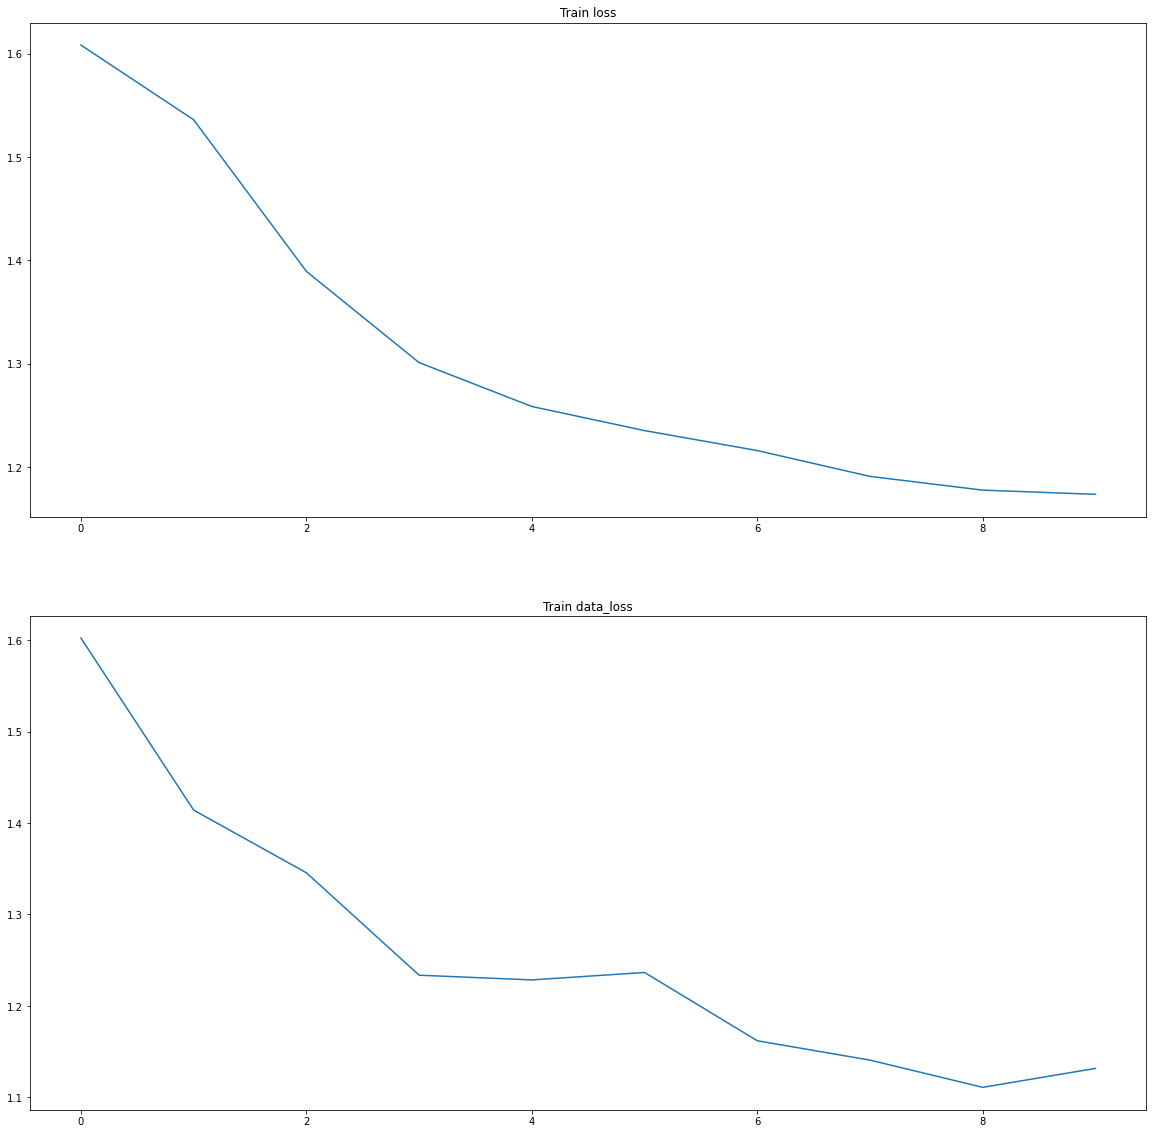

In [14]:
# Visualize train metrics

f, axarr = plt.subplots(len(train_metric_dict.keys()), 1, figsize=(20, 20))

for i, key in enumerate(train_metric_dict.keys()): 
    index = list(range(len(train_metric_dict[key])))
    vals = train_metric_dict[key]
    axarr[i].set_title(f"Train {key}")
    axarr[i].plot(index, vals)

The validation metrics that are logged include: 

#### AUC
AUC measures the likelihood that a random relevant item is ranked higher than a random irrelevant item. AUC is calculated based on the ranks given by the algorithm to all items — out of all possible pairs of type (relevant-item, non-relevant-item), AUC is a proportion of pairs where relevant-item was ranked higher than the irrelevant item from that pair.

<p align="center">
<img width="578" alt="image" src="https://user-images.githubusercontent.com/34798787/182898565-952432f9-38e0-48b9-94fe-85144acec6a6.png">
</p>


#### Normalized discounted cumulative gain (NDCG@K)
NDCG measures the overall reward at all positions that hold a relevant item. The reward is an inverse log of the position (i.e. higher ranks for relevant items would lead to better reward, as desired).

<p align="center">
<img width="578" alt="image" src="https://user-images.githubusercontent.com/34798787/182896608-d0f772dd-22c3-4bd8-80cd-925a954d5197.png">
</p>

The inverse log has a top-heavy property and therefore it’s suitable for evaluating recommendation systems.


<p align="center">
<img width="578" alt="image" src="https://user-images.githubusercontent.com/34798787/182897830-bfdde1e2-1b5f-42c1-9d76-a370ead875d1.png">
</p>

For more information regarding the aforementioned metrics, please refer to this [blog post](https://flowthytensor.medium.com/some-metrics-to-evaluate-recommendation-systems-9e0cf0c8b6cf#:~:text=AUC%20measures%20the%20likelihood%20that,meaning%20a%20better%20recommendation%20system.). 

We can visualize plot these metrics across metrics as follows:

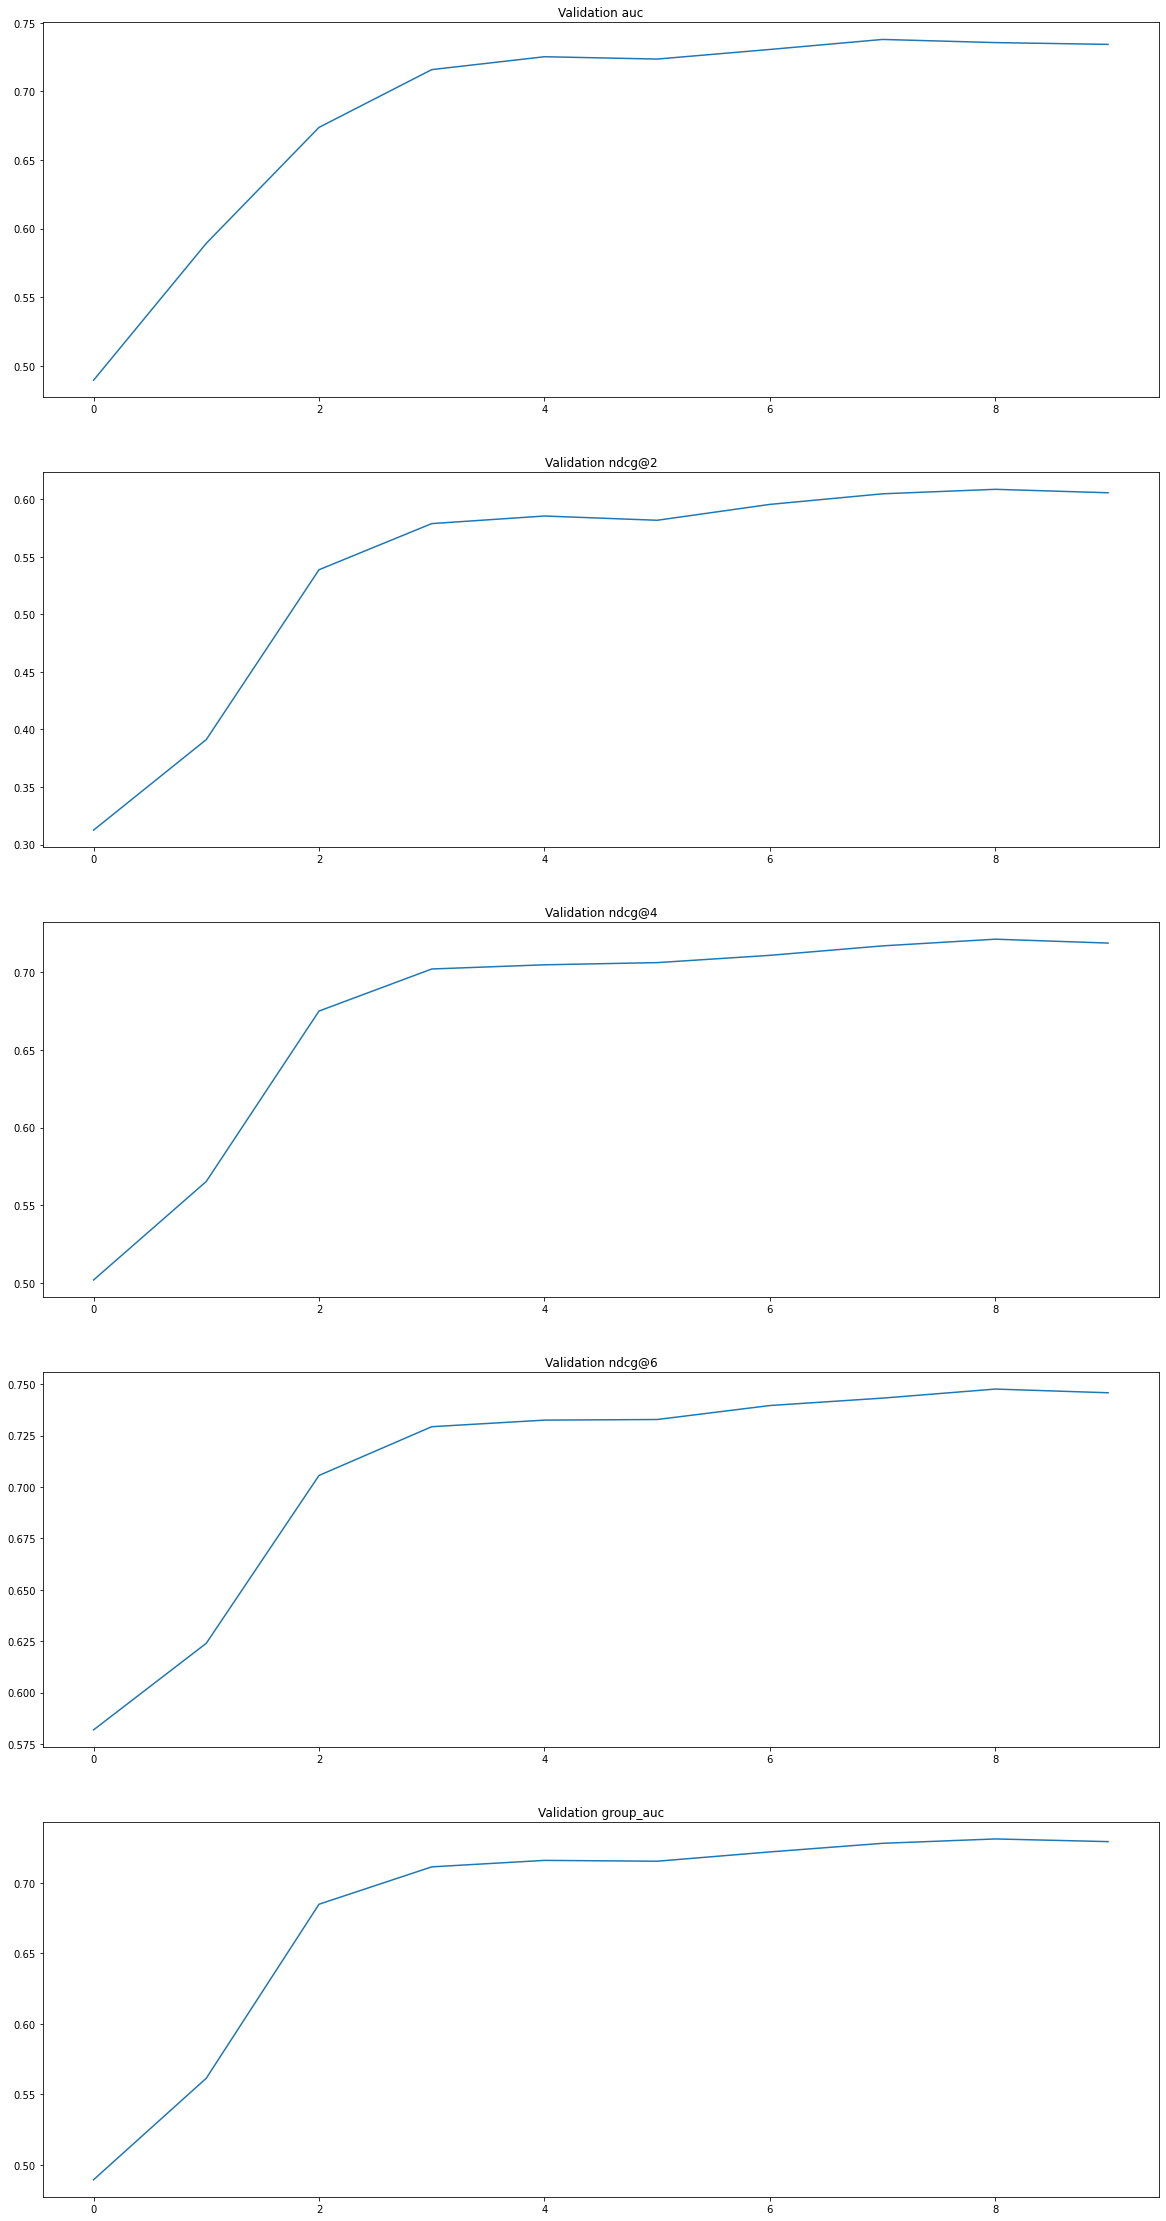

In [15]:
# Visualize eval metrics

f, axarr = plt.subplots(len(eval_metric_dict.keys()), 1, figsize=(20, 40))

for i, key in enumerate(eval_metric_dict.keys()): 
    index = list(range(len(eval_metric_dict[key])))
    vals = eval_metric_dict[key]
    axarr[i].set_title(f"Validation {key}")
    axarr[i].plot(index, vals)

## Testing

Now that are model is trained and validated, the last step is to evaluate the model on the held out test set. During training, the best performing model on the validation set across epochs is automatically saved. The `model.run_eval` method runs the evaluation precedure on the test set located in `test_path` using the best model from the train/validation step and returns the corresponding metrics. Below we run the evaluation on the SLi-Rec method and compare the results to the baseline method A2SVD. 

In [16]:
res = model.run_eval(test_path, num_ngs=test_num_ngs)

In [17]:
# Read results from ASVD 
asvd_res_df = pd.read_csv("amazon_results.csv")

In [18]:
# Generate SLi-rec results df 
res["name"] = "SLi-Rec"
res = {key: [val] for key, val in res.items()}
res_df = pd.DataFrame.from_dict(res)

In [19]:
amzn_res_df = pd.concat([asvd_res_df, res_df])
amzn_res_df

,auc,ndcg@2,ndcg@4,ndcg@6,group_auc,name
0,0.7170,0.3973,0.4997,0.5511,0.7059,SLi-Rec
0,0.7122,0.3910,0.4954,0.5476,0.7033,SLi-Rec


In [20]:
res_df.to_csv("amazon_results.csv", index=False)